In [1]:
import numpy as np
from numpy.polynomial.legendre import leggauss

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from ipywidgets import interact, FloatSlider, fixed

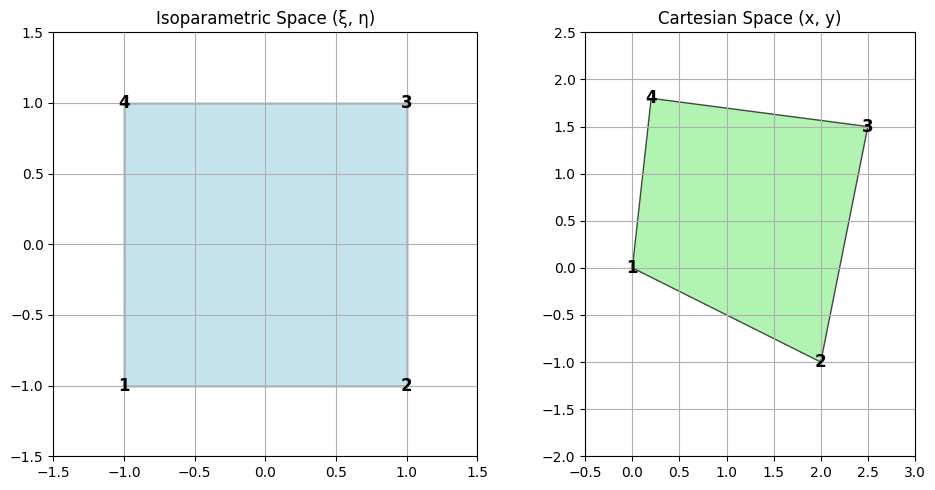

In [2]:

# Define nodal coordinates
# Cartesian coordinates (irregular quad)
nodes_cartesian = np.array([
    [0.0, 0.0],    # Node 1
    [2.0, -1],    # Node 2
    [2.5, 1.5],    # Node 3
    [0.2, 1.8]     # Node 4
])

# Isoparametric coordinates (square in [-1,1] x [-1,1])
nodes_iso = np.array([
    [-1.0, -1.0],  # Node 1
    [ 1.0, -1.0],  # Node 2
    [ 1.0,  1.0],  # Node 3
    [-1.0,  1.0]   # Node 4
])

# Material properties
E=210e9  # Young's modulus in Pa
nu=0.3  # Poisson's ratio
t=0.01  # Thickness in m

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Isoparametric space
ax1 = axes[0]
patch_iso = Polygon(nodes_iso, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.7)
ax1.add_patch(patch_iso)
for i, (x, y) in enumerate(nodes_iso, 1):
    ax1.text(x, y, f'{i}', ha='center', va='center', fontsize=12, weight='bold')
ax1.set_title('Isoparametric Space (ξ, η)')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.grid(True)

# Plot Cartesian space
ax2 = axes[1]
patch_cart = Polygon(nodes_cartesian, closed=True, edgecolor='black', facecolor='lightgreen', alpha=0.7)
ax2.add_patch(patch_cart)
for i, (x, y) in enumerate(nodes_cartesian, 1):
    ax2.text(x, y, f'{i}', ha='center', va='center', fontsize=12, weight='bold')
ax2.set_title('Cartesian Space (x, y)')
ax2.set_xlim(-0.5, 3)
ax2.set_ylim(-2, 2.5)
ax2.set_aspect('equal')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------
# Funciones de forma y sus derivadas
# ----------------------------------
def shape_functions(xi, eta):
    N1 = 0.25 * (1 - xi) * (1 - eta)
    N2 = 0.25 * (1 + xi) * (1 - eta)
    N3 = 0.25 * (1 + xi) * (1 + eta)
    N4 = 0.25 * (1 - xi) * (1 + eta)
    return np.array([[N1], [N2], [N3], [N4]])

def shape_function_derivatives(xi, eta):
    dN_dxi = np.array([
        [-0.25 * (1 - eta)],
        [ 0.25 * (1 - eta)],
        [ 0.25 * (1 + eta)],
        [-0.25 * (1 + eta)]
    ]).flatten()

    dN_deta = np.array([
        [-0.25 * (1 - xi)],
        [-0.25 * (1 + xi)],
        [ 0.25 * (1 + xi)],
        [ 0.25 * (1 - xi)]
    ]).flatten()

    return dN_dxi, dN_deta

# -------------------------------
# Jacobiano y su determinante
# -------------------------------
def jacobian_matrix(coords, xi, eta):
    dN_dxi, dN_deta = shape_function_derivatives(xi, eta)
    J = np.zeros((2, 2))
    for i in range(4):
        J[0, 0] += dN_dxi[i] * coords[i, 0]  # dx/dxi
        J[0, 1] += dN_dxi[i] * coords[i, 1]  # dy/dxi
        J[1, 0] += dN_deta[i] * coords[i, 0]  # dx/deta
        J[1, 1] += dN_deta[i] * coords[i, 1]  # dy/deta
    return J

def jacobian_determinant(J):
    return np.linalg.det(J)

# ----------------------------------------
# Derivadas parciales respecto a x, y
# ----------------------------------------
def shape_function_derivatives_global(coords, xi, eta):
    dN_dxi, dN_deta = shape_function_derivatives(xi, eta)
    J = jacobian_matrix(coords, xi, eta)
    J_inv = np.linalg.inv(J)

    dN_dx = []
    dN_dy = []
    for i in range(4):
        dN_nat = np.array([dN_dxi[i], dN_deta[i]])
        dN_phys = J_inv @ dN_nat
        dN_dx.append(dN_phys[0])
        dN_dy.append(dN_phys[1])
    return np.array(dN_dx), np.array(dN_dy)

# ---------------------------
# Matriz B (Strain-Displacement)
# ---------------------------
def strain_displacement_matrix(coords, xi, eta):
    dN_dx, dN_dy = shape_function_derivatives_global(coords, xi, eta)
    B = np.zeros((3, 8))
    for i in range(4):
        B[0, 2*i]     = dN_dx[i]  # ε_x
        B[1, 2*i + 1] = dN_dy[i]  # ε_y
        B[2, 2*i]     = dN_dy[i]  # γ_xy
        B[2, 2*i + 1] = dN_dx[i]
    return B

def generalized_interpolation(xi, eta, data_matrix):
    N = shape_functions(xi, eta)
    return (data_matrix @ N).flatten()

# -------------------------------
# Utility: Axis limits
# -------------------------------

def get_limits(coords, margin=0.5):
    x_min, y_min = np.min(coords, axis=0)
    x_max, y_max = np.max(coords, axis=0)
    return (x_min - margin, x_max + margin), (y_min - margin, y_max + margin)

def annotate_top_right(ax, value, fmt='.4f'):
    ax.annotate(
        f'{value:{fmt}}',
        xy=(0.98, 0.98),
        xycoords='axes fraction',
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)
    )

def compute_element_area(coords):
    """
    Compute area of a 4-node quadrilateral element from nodal geometry.

    Parameters:
    - coords: (4, 2) array with nodal coordinates ordered counter-clockwise

    Returns:
    - Area (float)
    """
    x = coords[:, 0]
    y = coords[:, 1]
    
    # Shoelace formula for polygon area
    area = 0.5 * abs(
        x[0]*y[1] + x[1]*y[2] + x[2]*y[3] + x[3]*y[0] -
        (y[0]*x[1] + y[1]*x[2] + y[2]*x[3] + y[3]*x[0])
    )
    return area

def constitutive_matrix(E=210e3, nu=0.3):
    """Plane stress constitutive matrix"""
    coef = E / (1 - nu**2)
    return coef * np.array([
        [1,     nu,    0],
        [nu,    1,     0],
        [0,     0, (1 - nu) / 2]
    ])

def integrand_trace(coords, xi, eta, E_mat, t=1.0):
    """Compute trace of B^T E B * |J| at a given xi, eta"""
    B = strain_displacement_matrix(coords, xi, eta)
    J = jacobian_matrix(coords, xi, eta)
    detJ = jacobian_determinant(J)
    K_local = B.T @ E_mat @ B
    return t * detJ * np.trace(K_local)

def compute_integrand_matrix(coords, xi, eta, E_mat, t=1.0):
    """
    Devuelve la matriz del integrando Bᵀ E B · |J| evaluada en (xi, eta)

    Parámetros:
    - coords : (4,2) coordenadas del elemento (ordenadas CCW)
    - xi, eta : coordenadas isoparamétricas de evaluación
    - E_mat : matriz constitutiva 3x3 (plane stress o plane strain)
    - t : espesor del elemento (default = 1.0)

    Retorna:
    - integrand_matrix : matriz 8x8 con Bᵀ E B · |J| · t
    """
    B = strain_displacement_matrix(coords, xi, eta)
    J = jacobian_matrix(coords, xi, eta)
    detJ = jacobian_determinant(J)

    return t * detJ * (B.T @ E_mat @ B)

def simpson_2d(f_grid, h_xi, h_eta):
    """
    Aplica regla de Simpson 2D compuesta a una grilla f_grid.
    Asume número impar de puntos (por ejemplo, 51 x 51).
    """
    if f_grid.shape[0] % 2 == 0 or f_grid.shape[1] % 2 == 0:
        raise ValueError("La regla de Simpson requiere un número impar de puntos en cada dimensión.")

    m, n = f_grid.shape
    S = 0

    for i in range(m):
        for j in range(n):
            coef_i = 2 + 2*(i % 2)
            coef_j = 2 + 2*(j % 2)
            if i == 0 or i == m-1:
                coef_i = 1
            if j == 0 or j == n-1:
                coef_j = 1
            S += coef_i * coef_j * f_grid[i, j]

    return (h_xi * h_eta / 9) * S

def gauss_points(n):
    """
    Devuelve las coordenadas y pesos de cuadratura de Gauss-Legendre para [-1, 1].
    """
    pts_1d, _ = leggauss(n)
    Ξ, Η = np.meshgrid(pts_1d, pts_1d)
    return np.column_stack((Ξ.flatten(), Η.flatten()))

def gauss_points(n):
    """
    Devuelve una lista de puntos de Gauss en [-1, 1]^2 con sus pesos combinados.

    Retorna:
    - points: array de shape (n^2, 2)
    - weights: array de shape (n^2,)
    """
    from numpy.polynomial.legendre import leggauss
    pts_1d, w_1d = leggauss(n)
    Ξ, Η = np.meshgrid(pts_1d, pts_1d)
    Wξ, Wη = np.meshgrid(w_1d, w_1d)
    points = np.column_stack((Ξ.flatten(), Η.flatten()))
    weights = (Wξ * Wη).flatten()
    return points, weights

def gauss_integrate_component(func, idx, coords, E_mat, n_gauss):
    """
    Integra K_{ii}(ξ, η) sobre el dominio usando cuadratura de Gauss-Legendre 2D.
    
    - func: función compute_integrand_matrix
    - idx: índice de componente K_{ii}
    - coords: coordenadas del elemento
    - E_mat: matriz constitutiva
    - n_gauss: orden de cuadratura (ej. 2 → 2x2 puntos)

    Retorna:
    - integral (float)
    """
    from numpy.polynomial.legendre import leggauss
    pts_1d, w_1d = leggauss(n_gauss)
    integral = 0.0

    for i in range(n_gauss):
        for j in range(n_gauss):
            ξ = pts_1d[i]
            η = pts_1d[j]
            w = w_1d[i] * w_1d[j]

            K_local = func(coords, ξ, η, E_mat)
            integral += w * K_local[idx, idx]
    
    return integral

def compute_stiffness_matrix(coords, E=210e9, nu=0.3, t=1.0, n_gauss=2):
    """
    Calcula la matriz de rigidez K de un elemento cuadrilátero isoparamétrico de 4 nodos.

    Parámetros:
    - coords : np.array (4,2), coordenadas del elemento (orden CCW)
    - E : módulo de Young
    - nu : coeficiente de Poisson
    - t : espesor del elemento
    - n_gauss : orden de integración de Gauss (n x n puntos)

    Retorna:
    - K : matriz de rigidez (8x8)
    """
    E_mat = constitutive_matrix(E, nu)
    points, weights = gauss_points(n_gauss)
    K = np.zeros((8, 8))

    for (ξ, η), w in zip(points, weights):
        B = strain_displacement_matrix(coords, ξ, η)
        J = jacobian_matrix(coords, ξ, η)
        detJ = jacobian_determinant(J)
        K += B.T @ E_mat @ B * detJ * t * w

    return K

def check_symmetry(K, tol=1e-6):
    """
    Verifica la simetría de la matriz de rigidez.

    Retorna el error absoluto máximo entre K y su transpuesta.
    """
    error = np.max(np.abs(K - K.T))
    return error

def rigid_body_modes():
    """
    Devuelve los vectores de desplazamientos para modos de cuerpo rígido:
    - Traslación en x
    - Traslación en y
    - Rotación alrededor del centroide
    """
    ux = np.array([1, 0]*4)  # [1,0,1,0,...]
    uy = np.array([0, 1]*4)  # [0,1,0,1,...]
    
    # Posiciones nodales (x,y)
    node_coords = nodes_cartesian
    cx, cy = np.mean(node_coords, axis=0)  # centroide
    rot = []
    for x, y in node_coords:
        dx = -(y - cy)
        dy =  (x - cx)
        rot.extend([dx, dy])
    rot = np.array(rot)
    
    return ux, uy, rot

def internal_energy(K, u):
    """
    Calcula la energía interna U = 0.5 * uᵀ K u
    """
    return 0.5 * u.T @ K @ u

def verify_rigid_body_modes(K, verbose=True):
    """
    Evalúa energía interna para los 3 modos de cuerpo rígido y muestra resultados.
    """
    ux, uy, rot = rigid_body_modes()
    
    e_x = internal_energy(K, ux)
    e_y = internal_energy(K, uy)
    e_r = internal_energy(K, rot)
    sym_err = check_symmetry(K)

    if verbose:
        print(f"Error de simetría: {sym_err:.6e} (debe ser ~0)")
        print(f"Energía para traslación en x: {e_x:.6e}")
        print(f"Energía para traslación en y: {e_y:.6e}")
        print(f"Energía para rotación: {e_r:.6e}")
    
    return sym_err, e_x, e_y, e_r




In [4]:
# --- Plotting function ---
def plot_mapping(xi, eta):
    clear_output(wait=True)

    data_matrix = np.vstack([nodes_cartesian[:, 0], nodes_cartesian[:, 1]])
    x_mapped, y_mapped = generalized_interpolation(xi, eta, data_matrix)

    iso_xlim, iso_ylim = get_limits(nodes_iso, 0.2)
    cart_xlim, cart_ylim = get_limits(nodes_cartesian, 0.5)

    fig = plt.figure(figsize=(18, 6), dpi=100, constrained_layout=True)
    gs = fig.add_gridspec(2, 4, height_ratios=[1.1, 1])

    # Top row (2 views)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Bottom row (4 shape functions)
    axs_sf = [fig.add_subplot(gs[1, i]) for i in range(4)]

    # --- Isoparametric view ---
    ax1.add_patch(Polygon(nodes_iso, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.6))
    for i, (x, y) in enumerate(nodes_iso, 1):
        ax1.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax1.plot(xi, eta, 'ro', markersize=10)
    ax1.set_title('Isoparametric Space $(\\xi, \\eta)$', fontsize=12)
    ax1.set_xlim(*iso_xlim)
    ax1.set_ylim(*iso_ylim)
    ax1.set_aspect('equal')
    ax1.grid(True)

    # --- Cartesian view ---
    ax2.add_patch(Polygon(nodes_cartesian, closed=True, edgecolor='black', facecolor='lightgreen', alpha=0.6))
    for i, (x, y) in enumerate(nodes_cartesian, 1):
        ax2.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax2.plot(x_mapped, y_mapped, 'ro', markersize=10)
    ax2.set_title('Cartesian Space $(x, y)$', fontsize=12)
    ax2.set_xlim(*cart_xlim)
    ax2.set_ylim(*cart_ylim)
    ax2.set_aspect('equal')
    ax2.grid(True)

    # --- Shape function plots ---
    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)
    sξ = np.array([-1, 1, 1, -1])
    sη = np.array([-1, -1, 1, 1])

    for i, ax in enumerate(axs_sf):
        Ni = 0.25 * (1 + sξ[i]*Ξ) * (1 + sη[i]*Η)
        Ni_val = 0.25 * (1 + sξ[i]*xi) * (1 + sη[i]*eta)

        ax.contourf(Ξ, Η, Ni, levels=20, cmap='viridis')
        ax.plot(xi, eta, 'ro', markersize=6)
        ax.set_title(f'$N_{i+1}(\\xi, \\eta)$', fontsize=11)
        ax.set_xlim(-1.05, 1.05)
        ax.set_ylim(-1.05, 1.05)
        ax.set_aspect('equal')
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.grid(True)

        # Añadir anotación del valor en la esquina superior derecha
        annotate_top_right(ax, Ni_val)

    plt.show()

# --- Widget setup ---
interact(
    plot_mapping,
    xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
    eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η')
);

interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [5]:
# Plotting
def plot_mapping(xi, eta):
    clear_output(wait=True)

    data_matrix = np.vstack([nodes_cartesian[:, 0], nodes_cartesian[:, 1]])
    x_mapped, y_mapped = generalized_interpolation(xi, eta, data_matrix)
    iso_xlim, iso_ylim = get_limits(nodes_iso, 0.2)
    cart_xlim, cart_ylim = get_limits(nodes_cartesian, 0.5)

    # New layout: 2 rows, 4 columns → row 0: views, row 1: shape functions
    fig = plt.figure(figsize=(18, 6), dpi=100, constrained_layout=True)
    gs = fig.add_gridspec(2, 4, height_ratios=[1.1, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    axs_3d = [fig.add_subplot(gs[1, i], projection='3d') for i in range(4)]

    # Isoparametric space
    ax1.add_patch(Polygon(nodes_iso, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.6))
    for i, (x, y) in enumerate(nodes_iso, 1):
        ax1.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax1.plot(xi, eta, 'ro', markersize=10)
    ax1.set_title('Isoparametric Space $(\\xi, \\eta)$', fontsize=13)
    ax1.set_xlim(*iso_xlim)
    ax1.set_ylim(*iso_ylim)
    ax1.set_aspect('equal')
    ax1.grid(True)

    # Cartesian space
    ax2.add_patch(Polygon(nodes_cartesian, closed=True, edgecolor='black', facecolor='lightgreen', alpha=0.6))
    for i, (x, y) in enumerate(nodes_cartesian, 1):
        ax2.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax2.plot(x_mapped, y_mapped, 'ro', markersize=10)
    ax2.set_title('Cartesian Space $(x, y)$', fontsize=13)
    ax2.set_xlim(*cart_xlim)
    ax2.set_ylim(*cart_ylim)
    ax2.set_aspect('equal')
    ax2.grid(True)

    # Shape function surfaces
    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)
    sξ = np.array([-1, 1, 1, -1])
    sη = np.array([-1, -1, 1, 1])

    for i, ax in enumerate(axs_3d):
        Ni = 0.25 * (1 + sξ[i] * Ξ) * (1 + sη[i] * Η)
        ax.plot_surface(Ξ, Η, Ni, cmap='viridis', edgecolor='k', linewidth=0.2, alpha=0.9)
        ax.scatter(xi, eta, shape_functions(xi, eta)[i, 0], color='r', s=30)
        ax.set_title(f'$N_{i+1}(\\xi, \\eta)$', fontsize=11)
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_zlabel(f'$N_{i+1}$')
        ax.view_init(elev=30, azim=-45)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(0, 1)

    fig.suptitle('Quad4 Shape Functions as 3D Surfaces', fontsize=15, fontweight='bold')
    plt.show()

# Interactive widget
interact(plot_mapping,
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));

interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [6]:
# --- Función principal de visualización ---
def plot_mapping(xi, eta):
    clear_output(wait=True)

    data_matrix = np.vstack([nodes_cartesian[:, 0], nodes_cartesian[:, 1]])
    x_mapped, y_mapped = generalized_interpolation(xi, eta, data_matrix)

    iso_xlim, iso_ylim = get_limits(nodes_iso, 0.2)
    cart_xlim, cart_ylim = get_limits(nodes_cartesian, 0.5)

    fig = plt.figure(figsize=(20, 14), dpi=100, constrained_layout=True)
    gs = fig.add_gridspec(4, 5, height_ratios=[1.1, 1, 1, 1])

    # --- Top row (Isoparametric and Cartesian view)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # --- Shape functions
    axs_sf = [fig.add_subplot(gs[1, i]) for i in range(4)]

    # --- Partial derivatives: dNi/dξ and dNi/dη
    axs_dxi = [fig.add_subplot(gs[2, i]) for i in range(4)]
    axs_deta = [fig.add_subplot(gs[3, i]) for i in range(4)]

    # --- Isoparametric view ---
    ax1.add_patch(Polygon(nodes_iso, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.6))
    for i, (x, y) in enumerate(nodes_iso, 1):
        ax1.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax1.plot(xi, eta, 'ro', markersize=10)
    ax1.set_title('Isoparametric Space $(\\xi, \\eta)$', fontsize=12)
    ax1.set_xlim(*iso_xlim)
    ax1.set_ylim(*iso_ylim)
    ax1.set_aspect('equal')
    ax1.grid(True)

    # --- Cartesian view ---
    ax2.add_patch(Polygon(nodes_cartesian, closed=True, edgecolor='black', facecolor='lightgreen', alpha=0.6))
    for i, (x, y) in enumerate(nodes_cartesian, 1):
        ax2.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax2.plot(x_mapped, y_mapped, 'ro', markersize=10)
    ax2.set_title('Cartesian Space $(x, y)$', fontsize=12)
    ax2.set_xlim(*cart_xlim)
    ax2.set_ylim(*cart_ylim)
    ax2.set_aspect('equal')
    ax2.grid(True)

    # --- Grid definition
    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    for i in range(4):
        # Evaluar función de forma y derivadas con las funciones definidas
        Ni_grid = np.zeros_like(Ξ)
        dNi_dxi_grid = np.zeros_like(Ξ)
        dNi_deta_grid = np.zeros_like(Ξ)

        for idx in range(res):
            for jdx in range(res):
                ξ_val, η_val = Ξ[idx, jdx], Η[idx, jdx]
                N_vals = shape_functions(ξ_val, η_val).flatten()
                dN_dxi, dN_deta = shape_function_derivatives(ξ_val, η_val)
                Ni_grid[idx, jdx] = N_vals[i]
                dNi_dxi_grid[idx, jdx] = dN_dxi[i]
                dNi_deta_grid[idx, jdx] = dN_deta[i]

        # Valores en el punto actual
        N_point = shape_functions(xi, eta).flatten()[i]
        dN_dxi_point, dN_deta_point = shape_function_derivatives(xi, eta)
        dN_dxi_val = dN_dxi_point[i]
        dN_deta_val = dN_deta_point[i]

        # --- Ni ---
        axs_sf[i].contourf(Ξ, Η, Ni_grid, levels=20, cmap='viridis')
        axs_sf[i].plot(xi, eta, 'ro', markersize=6)
        axs_sf[i].set_title(f'$N_{i+1}(\\xi, \\eta)$', fontsize=11)
        axs_sf[i].set_xlim(-1.05, 1.05)
        axs_sf[i].set_ylim(-1.05, 1.05)
        axs_sf[i].set_aspect('equal')
        axs_sf[i].set_xlabel('ξ')
        axs_sf[i].set_ylabel('η')
        axs_sf[i].grid(True)
        annotate_top_right(axs_sf[i], N_point)

        # --- ∂Ni/∂ξ ---
        axs_dxi[i].contourf(Ξ, Η, dNi_dxi_grid, levels=20, cmap='coolwarm')
        axs_dxi[i].plot(xi, eta, 'ro', markersize=6)
        axs_dxi[i].set_title(f'$\\partial N_{i+1}/\\partial \\xi$', fontsize=11)
        axs_dxi[i].set_xlim(-1.05, 1.05)
        axs_dxi[i].set_ylim(-1.05, 1.05)
        axs_dxi[i].set_aspect('equal')
        axs_dxi[i].set_xlabel('ξ')
        axs_dxi[i].set_ylabel('η')
        axs_dxi[i].grid(True)
        annotate_top_right(axs_dxi[i], dN_dxi_val)

        # --- ∂Ni/∂η ---
        axs_deta[i].contourf(Ξ, Η, dNi_deta_grid, levels=20, cmap='cividis')
        axs_deta[i].plot(xi, eta, 'ro', markersize=6)
        axs_deta[i].set_title(f'$\\partial N_{i+1}/\\partial \\eta$', fontsize=11)
        axs_deta[i].set_xlim(-1.05, 1.05)
        axs_deta[i].set_ylim(-1.05, 1.05)
        axs_deta[i].set_aspect('equal')
        axs_deta[i].set_xlabel('ξ')
        axs_deta[i].set_ylabel('η')
        axs_deta[i].grid(True)
        annotate_top_right(axs_deta[i], dN_deta_val)

    # --- Visualización de la matriz B estilo LaTeX en fila 1, columnas 3 y 4 ---
    axB = fig.add_subplot(gs[0, 2:4])
    axB.axis('off')
    B = strain_displacement_matrix(nodes_cartesian, xi, eta)

    col_labels = [f"$u_{i+1}$" for i in range(8)]
    row_labels = [r"$\varepsilon_x$", r"$\varepsilon_y$", r"$\gamma_{xy}$"]

    # Construcción de la tabla como strings
    table_data = [[f"{B[i, j]:.2e}" for j in range(B.shape[1])] for i in range(B.shape[0])]

    # Mostrar la tabla
    table = axB.table(
        cellText=table_data,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='center',
        cellLoc='center',
        colLoc='center',
        edges='closed'
    )

    table.scale(1.2, 1.8)
    table.set_fontsize(10)
    axB.set_title('Strain-Displacement Matrix $[B]$', fontsize=14, pad=10)

    plt.show()


# --- Widget interactivo ---
interact(plot_mapping,
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));

interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [7]:
area= compute_element_area(nodes_cartesian)

def plot_jacobian_fields(xi, eta):
    clear_output(wait=True)

    # --- Setup de grilla ---
    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    J11 = np.zeros_like(Ξ)
    J12 = np.zeros_like(Ξ)
    J21 = np.zeros_like(Ξ)
    J22 = np.zeros_like(Ξ)
    detJ_grid = np.zeros_like(Ξ)

    for i in range(res):
        for j in range(res):
            ξ = Ξ[i, j]
            η = Η[i, j]
            J = jacobian_matrix(nodes_cartesian, ξ, η)
            J11[i, j] = J[0, 0]
            J12[i, j] = J[0, 1]
            J21[i, j] = J[1, 0]
            J22[i, j] = J[1, 1]
            detJ_grid[i, j] = np.linalg.det(J)

    # Punto transformado
    data_matrix = np.vstack([nodes_cartesian[:, 0], nodes_cartesian[:, 1]])
    x_mapped, y_mapped = generalized_interpolation(xi, eta, data_matrix)

    iso_xlim, iso_ylim = get_limits(nodes_iso, 0.2)
    cart_xlim, cart_ylim = get_limits(nodes_cartesian, 0.5)

    fig, axs = plt.subplots(3, 3, figsize=(18, 14), dpi=100, constrained_layout=True)

    # --- Espacio isoparamétrico ---
    ax_iso = axs[0, 0]
    ax_iso.add_patch(Polygon(nodes_iso, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.6))
    for i, (x, y) in enumerate(nodes_iso, 1):
        ax_iso.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax_iso.plot(xi, eta, 'ro', markersize=8)
    ax_iso.set_title('Espacio Isoparamétrico $(\\xi, \\eta)$')
    ax_iso.set_xlim(*iso_xlim)
    ax_iso.set_ylim(*iso_ylim)
    ax_iso.set_aspect('equal')
    ax_iso.grid(True)

    # --- Espacio cartesiano ---
    ax_cart = axs[0, 1]
    ax_cart.add_patch(Polygon(nodes_cartesian, closed=True, edgecolor='black', facecolor='lightgreen', alpha=0.6))
    for i, (x, y) in enumerate(nodes_cartesian, 1):
        ax_cart.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')
    ax_cart.plot(x_mapped, y_mapped, 'ro', markersize=8)
    ax_cart.set_title('Espacio Físico $(x, y)$')
    ax_cart.set_xlim(*cart_xlim)
    ax_cart.set_ylim(*cart_ylim)
    ax_cart.set_aspect('equal')
    ax_cart.grid(True)

    # --- Det J ---
    c3 = axs[0, 2].contourf(Ξ, Η, detJ_grid, levels=20, cmap='viridis')
    axs[0, 2].plot(xi, eta, 'ro')
    axs[0, 2].set_title(r'Determinante $|J|$')
    axs[0, 2].set_aspect('equal')
    fig.colorbar(c3, ax=axs[0, 2])

    # --- J11 ---
    c11 = axs[1, 0].contourf(Ξ, Η, J11, levels=20, cmap='coolwarm')
    axs[1, 0].plot(xi, eta, 'ro')
    axs[1, 0].set_title(r"$\partial x / \partial \xi$")
    axs[1, 0].set_aspect('equal')
    fig.colorbar(c11, ax=axs[1, 0])

    # --- J12 ---
    c12 = axs[1, 1].contourf(Ξ, Η, J12, levels=20, cmap='coolwarm')
    axs[1, 1].plot(xi, eta, 'ro')
    axs[1, 1].set_title(r"$\partial y / \partial \xi$")
    axs[1, 1].set_aspect('equal')
    fig.colorbar(c12, ax=axs[1, 1])

    # --- J21 ---
    c21 = axs[2, 0].contourf(Ξ, Η, J21, levels=20, cmap='cividis')
    axs[2, 0].plot(xi, eta, 'ro')
    axs[2, 0].set_title(r"$\partial x / \partial \eta$")
    axs[2, 0].set_aspect('equal')
    fig.colorbar(c21, ax=axs[2, 0])

    # --- J22 ---
    c22 = axs[2, 1].contourf(Ξ, Η, J22, levels=20, cmap='cividis')
    axs[2, 1].plot(xi, eta, 'ro')
    axs[2, 1].set_title(r"$\partial y / \partial \eta$")
    axs[2, 1].set_aspect('equal')
    fig.colorbar(c22, ax=axs[2, 1])

    # Det over area
    xx=axs[1, 2].contourf(Ξ, Η, detJ_grid/area, levels=20, cmap='viridis')
    axs[1, 2].plot(xi, eta, 'ro')
    axs[1, 2].set_title(r'Determinante $|J|$ / Area')
    axs[1, 2].set_aspect('equal')
    fig.colorbar(xx, ax=axs[1, 2])


    # --- Oculta el último subplot vacío ---
    axs[2, 2].axis('off')

    # Evalúa J y det(J) en el punto actual (xi, eta)
    J_at_pt = jacobian_matrix(nodes_cartesian, xi, eta)
    detJ_at_pt = jacobian_determinant(J_at_pt)
    detJ_at_pt_area = jacobian_determinant(J_at_pt)/area

    # Anota en cada subplot el valor evaluado en el punto (xi, eta)
    annotate_top_right(axs[0, 2], detJ_at_pt, fmt='.2e')        # det(J)
    annotate_top_right(axs[1, 2], detJ_at_pt_area, fmt='.3')        # det(J)/Area
    annotate_top_right(axs[1, 0], J_at_pt[0, 0], fmt='.2e')      # ∂x/∂ξ
    annotate_top_right(axs[1, 1], J_at_pt[0, 1], fmt='.2e')      # ∂y/∂ξ
    annotate_top_right(axs[2, 0], J_at_pt[1, 0], fmt='.2e')      # ∂x/∂η
    annotate_top_right(axs[2, 1], J_at_pt[1, 1], fmt='.2e')      # ∂y/∂η
    
    plt.show()

# --- Widget interactivo ---
interact(plot_jacobian_fields,
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));


interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [8]:
Emat= constitutive_matrix(E=E, nu=nu)

In [9]:
def plot_stiffness_integrand(E_mat, xi_eval=0.0, eta_eval=0.0):
    clear_output(wait=True)

    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    Z = np.zeros_like(Ξ)
    for i in range(res):
        for j in range(res):
            Z[i, j] = integrand_trace(nodes_cartesian, Ξ[i, j], Η[i, j], E_mat)

    Z_point = integrand_trace(nodes_cartesian, xi_eval, eta_eval, E_mat)

    fig = plt.figure(figsize=(16, 6))
    
    # Contour
    ax1 = fig.add_subplot(1, 2, 1)
    c = ax1.contourf(Ξ, Η, Z, levels=30, cmap='viridis')
    ax1.plot(xi_eval, eta_eval, 'ro')
    annotate_top_right(ax1, Z_point, fmt='.2e')
    ax1.set_title(r'Traza del Integrando $B^T E B \, |J|$')
    ax1.set_xlabel('ξ')
    ax1.set_ylabel('η')
    fig.colorbar(c, ax=ax1)
    ax1.grid(True)
    ax1.set_aspect('equal')

    # 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(Ξ, Η, Z, cmap='viridis', edgecolor='k', alpha=0.95, linewidth=0.1)
    ax2.scatter(xi_eval, eta_eval, Z_point, color='r', s=30)
    ax2.set_title('Integrando en 3D')
    ax2.set_xlabel('ξ')
    ax2.set_ylabel('η')
    ax2.set_zlabel('Valor Escalar')
    ax2.view_init(elev=30, azim=-45)

    plt.tight_layout()
    plt.show()
    

interact(lambda xi, eta: plot_stiffness_integrand(Emat, xi, eta),
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));



interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [10]:
def plot_stiffness_diagonal_interactive(E_mat, xi=0.0, eta=0.0):
    clear_output(wait=True)

    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
    axs = axs.flatten()

    for idx in range(8):
        Z = np.zeros_like(Ξ)
        for r in range(res):
            for c in range(res):
                K_loc = compute_integrand_matrix(nodes_cartesian, Ξ[r, c], Η[r, c], E_mat)
                Z[r, c] = K_loc[idx, idx]

        Z_point = compute_integrand_matrix(nodes_cartesian, xi, eta, E_mat)[idx, idx]

        ax = axs[idx]
        contour = ax.contourf(Ξ, Η, Z, levels=30, cmap='viridis')
        ax.plot(xi, eta, 'ro')
        annotate_top_right(ax, Z_point, fmt='.2e')
        ax.set_title(rf'$K_{{{idx+1},{idx+1}}}(\xi, \eta)$', fontsize=11)
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_aspect('equal')
        ax.grid(True)
        fig.colorbar(contour, ax=ax)

    fig.suptitle('Componentes Diagonales del Integrando $B^T E B \cdot |J|$', fontsize=16, fontweight='bold')
    plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
/var/folders/js/wns9brx16sqfldmkkfbn28cm0000gn/T/ipykernel_23030/248701192.py:31: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle('Componentes Diagonales del Integrando $B^T E B \cdot |J|$', fontsize=16, fontweight='bold')


In [11]:
interact(plot_stiffness_diagonal_interactive,
         E_mat=fixed(Emat),  # Tu matriz constitutiva
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));


interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [12]:
def plot_stiffness_diagonal_interactive_3D(E_mat, xi=0.0, eta=0.0):
    clear_output(wait=True)

    res = 51  # impar para Simpson
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)
    h = 2 / (res - 1)

    fig = plt.figure(figsize=(24, 10), constrained_layout=True)
    axs = [fig.add_subplot(2, 4, i + 1, projection='3d') for i in range(8)]

    for idx, ax in enumerate(axs):
        Z = np.zeros_like(Ξ)
        for r in range(res):
            for c in range(res):
                K_loc = compute_integrand_matrix(nodes_cartesian, Ξ[r, c], Η[r, c], E_mat)
                Z[r, c] = K_loc[idx, idx]

        # Valor puntual
        K_pt = compute_integrand_matrix(nodes_cartesian, xi, eta, E_mat)[idx, idx]
        volume = simpson_2d(Z, h, h)

        # Plot
        surf = ax.plot_surface(Ξ, Η, Z, cmap='viridis', edgecolor='k', linewidth=0.1, alpha=0.95)
        ax.scatter(xi, eta, K_pt, color='r', s=30)
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_zlabel(rf'$K_{{{idx+1},{idx+1}}}$')
        ax.set_title(rf'$K_{{{idx+1},{idx+1}}}(\xi, \eta)$', fontsize=10)
        ax.view_init(elev=30, azim=-45)

        # Texto debajo del gráfico con el volumen integrado
        ax.text2D(0.5, -0.15, f'Vol = {volume:.2e}', transform=ax.transAxes,
                  ha='center', fontsize=9, bbox=dict(boxstyle='round', fc='wheat', alpha=0.3))

    fig.suptitle('Componentes Diagonales (3D) del Integrando $B^T E B \cdot |J|$', fontsize=16, fontweight='bold')
    plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
/var/folders/js/wns9brx16sqfldmkkfbn28cm0000gn/T/ipykernel_23030/3517750613.py:36: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle('Componentes Diagonales (3D) del Integrando $B^T E B \cdot |J|$', fontsize=16, fontweight='bold')


In [13]:
interact(plot_stiffness_diagonal_interactive_3D,
         E_mat=fixed(Emat),
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'));


interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [14]:
def plot_stiffness_diagonal_interactive(E_mat, xi=0.0, eta=0.0, n_gauss=2):
    clear_output(wait=True)

    res = 50
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    # Obtener puntos y pesos de Gauss
    gauss_pts, gauss_wts = gauss_points(n_gauss)

    fig, axs = plt.subplots(2, 4, figsize=(22, 10), constrained_layout=True)
    axs = axs.flatten()

    for idx in range(8):
        Z = np.zeros_like(Ξ)
        for r in range(res):
            for c in range(res):
                K_loc = compute_integrand_matrix(nodes_cartesian, Ξ[r, c], Η[r, c], E_mat)
                Z[r, c] = K_loc[idx, idx]

        Z_point = compute_integrand_matrix(nodes_cartesian, xi, eta, E_mat)[idx, idx]

        ax = axs[idx]
        contour = ax.contourf(Ξ, Η, Z, levels=30, cmap='viridis')
        ax.plot(xi, eta, 'ro', label='Punto actual')

        # Plot y etiqueta de puntos de Gauss
        for (ξi, ηi), wi in zip(gauss_pts, gauss_wts):
            ax.plot(ξi, ηi, 'ko', markersize=6, zorder=5)
            ax.text(ξi, ηi + 0.08, f'({ξi:.2f}, {ηi:.2f})', fontsize=8,
                    ha='center', va='bottom', color='black',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.85),
                    zorder=6)
            ax.text(ξi, ηi - 0.08, f'$w$={wi:.3f}', fontsize=8,
                    ha='center', va='top', color='black',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.85),
                    zorder=6)

        annotate_top_right(ax, Z_point, fmt='.2e')
        ax.set_title(rf'$K_{{{idx+1},{idx+1}}}(\xi, \eta)$', fontsize=11)
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_aspect('equal')
        ax.grid(True)
        fig.colorbar(contour, ax=ax)

    fig.suptitle('Componentes Diagonales $B^T E B \cdot |J|$ con Puntos y Pesos de Gauss', fontsize=16, fontweight='bold')
    plt.show()


<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
/var/folders/js/wns9brx16sqfldmkkfbn28cm0000gn/T/ipykernel_23030/3522913003.py:47: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle('Componentes Diagonales $B^T E B \cdot |J|$ con Puntos y Pesos de Gauss', fontsize=16, fontweight='bold')


In [ ]:
from ipywidgets import IntSlider

interact(plot_stiffness_diagonal_interactive,
         E_mat=fixed(Emat),
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'),
         n_gauss=IntSlider(min=1, max=5, step=1, value=2, description='Gauss'));


interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [16]:
def plot_stiffness_diagonal_interactive_3D(E_mat, xi=0.0, eta=0.0, n_gauss=2):
    clear_output(wait=True)

    res = 51  # Para visualización fina
    ξg, ηg = np.linspace(-1, 1, res), np.linspace(-1, 1, res)
    Ξ, Η = np.meshgrid(ξg, ηg)

    fig = plt.figure(figsize=(24, 10), constrained_layout=True)
    axs = [fig.add_subplot(2, 4, i + 1, projection='3d') for i in range(8)]

    for idx, ax in enumerate(axs):
        Z = np.zeros_like(Ξ)
        for r in range(res):
            for c in range(res):
                K_loc = compute_integrand_matrix(nodes_cartesian, Ξ[r, c], Η[r, c], E_mat)
                Z[r, c] = K_loc[idx, idx]

        # Evaluación puntual y volumen con Gauss
        K_pt = compute_integrand_matrix(nodes_cartesian, xi, eta, E_mat)[idx, idx]
        volume = gauss_integrate_component(compute_integrand_matrix, idx, nodes_cartesian, E_mat, n_gauss)

        # Plot
        ax.plot_surface(Ξ, Η, Z, cmap='viridis', edgecolor='k', linewidth=0.1, alpha=0.95)
        ax.scatter(xi, eta, K_pt, color='r', s=30)
        ax.set_xlabel('ξ')
        ax.set_ylabel('η')
        ax.set_zlabel(rf'$K_{{{idx+1},{idx+1}}}$')
        ax.set_title(rf'$K_{{{idx+1},{idx+1}}}(\xi, \eta)$', fontsize=10)
        ax.view_init(elev=30, azim=-45)

        # Mostrar el volumen debajo
        ax.text2D(0.5, -0.15, f'Gauss ({n_gauss}×{n_gauss}) Vol = {volume:.2e}',
                  transform=ax.transAxes, ha='center', fontsize=9,
                  bbox=dict(boxstyle='round', fc='wheat', alpha=0.3))

    fig.suptitle('Componentes Diagonales (3D) con Cuadratura de Gauss', fontsize=16, fontweight='bold')
    plt.show()


In [17]:
interact(plot_stiffness_diagonal_interactive_3D,
         E_mat=fixed(Emat),
         xi=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='ξ'),
         eta=FloatSlider(min=-1.0, max=1.0, step=0.05, value=0.0, description='η'),
         n_gauss=IntSlider(min=1, max=5, step=1, value=2, description='Gauss'));


interactive(children=(FloatSlider(value=0.0, description='ξ', max=1.0, min=-1.0, step=0.05), FloatSlider(value…

In [26]:
np.set_printoptions(precision=3, suppress=True, linewidth=200)

K = compute_stiffness_matrix(nodes_cartesian, E=E, nu=nu, t=t, n_gauss=2)
verify_rigid_body_modes(K)
print("Stiffness Matrix [K]:")
print(K)

Error de simetría: 2.980232e-08 (debe ser ~0)
Energía para traslación en x: -2.160668e-07
Energía para traslación en y: 1.490116e-07
Energía para rotación: 6.169081e-07
Stiffness Matrix [K]:
[[ 1.466e+09  4.154e+08 -5.959e+08  1.191e+08 -8.109e+08 -3.731e+08 -5.918e+07 -1.613e+08]
 [ 4.154e+08  1.098e+09  1.768e+08  8.560e+07 -3.731e+08 -4.632e+08 -2.190e+08 -7.203e+08]
 [-5.959e+08  1.768e+08  7.298e+08 -2.769e+08  1.296e+08 -2.069e+08 -2.634e+08  3.070e+08]
 [ 1.191e+08  8.560e+07 -2.769e+08  1.033e+09 -1.492e+08 -5.374e+08  3.070e+08 -5.809e+08]
 [-8.109e+08 -3.731e+08  1.296e+08 -1.492e+08  1.233e+09  4.003e+08 -5.515e+08  1.220e+08]
 [-3.731e+08 -4.632e+08 -2.069e+08 -5.374e+08  4.003e+08  8.720e+08  1.797e+08  1.286e+08]
 [-5.918e+07 -2.190e+08 -2.634e+08  3.070e+08 -5.515e+08  1.797e+08  8.741e+08 -2.676e+08]
 [-1.613e+08 -7.203e+08  3.070e+08 -5.809e+08  1.220e+08  1.286e+08 -2.676e+08  1.173e+09]]
